<a href="https://colab.research.google.com/github/LazaroR-u/EQNN/blob/main/EQNN_p4m_mnist_train_jax.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# p4m EQNN

In this notebook, we build the invariant Equivariant Quantum Neural Network under the p4m symmetry, consisting of the reflections over the X and Y axis, and the rotatations by 90 degrees.

We test the invariance of this model using the MNIST dataset and local transformations to perform reflections and rotations over the data.

The main reference is:

Approximately Equivariant Quantum Neural Network for $p4m$ Group Symmetries in Images. https://arxiv.org/abs/2310.02323.

# dataset

In [1]:
%%capture
pip install pennylane jax jaxlib

## Quark-Gluon

In [2]:
import pennylane as qml
from pennylane import numpy as np
import jax
from jax import numpy as jnp
import optax
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

In [33]:
#NR
def preprocess_jnp(
    classes: jnp.ndarray, trainloader: DataLoader, testloader: DataLoader
):
    r"""Load Data from PyTorch DataLoader into JAX NumPy Arrays

    Args:
        classes (jnp.ndarray) : List of integers representing data classes to be loaded.
            If None, return all classes.
        trainloader (torch.utils.data.DataLoader) : Trainset loader.
        testloader (torch.utils.data.DataLoader) : Testset loader.

    Returns:
        Tuple[jnp.ndarray, ...]: Tuple of training and test data/labels. The outputs are
        ordered as follows:

        * ``X_train``: Training samples of shape ``(num_train, img_size, img_size,
          num_channel)``.
        * ``Y_train``: Training labels of shape ``(num_train, )``.
        * ``X_test``: Test samples of shape ``(num_test, img_size, img_size,
          num_channel)``.
        * ``Y_train``: Test labels of shape ``(num_test, )``.
    """
    X_train = []
    Y_train = []

    X_test = []
    Y_test = []

    print(classes)
    # Load data as a np.ndarray
    for i, data in enumerate(trainloader, 0):
        image, label = data
        X_train.extend(list(jnp.transpose(image.detach().numpy(), (0, 2, 3, 1))))
        Y_train.extend(list(label.detach().numpy()))

    for i, data in enumerate(testloader, 0):
        image, label = data
        X_test.extend(list(jnp.transpose(image.detach().numpy(), (0, 2, 3, 1))))
        Y_test.extend(list(label.detach().numpy()))

    X_train = jnp.array(X_train)
    Y_train = jnp.array(Y_train)

    X_test = jnp.array(X_test)
    Y_test = jnp.array(Y_test)

    if classes is not None:
        train_mask = np.isin(Y_train, classes)
        X_train = X_train[train_mask]
        Y_train = Y_train[train_mask]

        Y_train = Y_train.at[jnp.argwhere(Y_train == classes[0])].set(0.0)
        Y_train = Y_train.at[jnp.argwhere(Y_train == classes[1])].set(1.0)

        test_mask = np.isin(Y_test, classes)
        X_test = X_test[test_mask]
        Y_test = Y_test[test_mask]
        Y_test = Y_test.at[jnp.argwhere(Y_test == classes[0])].set(0.0)
        Y_test = Y_test.at[jnp.argwhere(Y_test == classes[1])].set(1.0)

    return X_train, Y_train, X_test, Y_test


import torch
import torchvision
import torchvision.datasets as datasets

load_dir = "/content/dataset"
img_size = 16
classes = [0, 1]


# Here we perform the symmetry operations to the data: Flip over X and Y axis and rotations per 90 degrees.
transform = transforms.Compose(
                [
                    transforms.Resize([img_size, img_size]),
                    transforms.ToTensor(),
                    transforms.RandomHorizontalFlip(),
                    transforms.RandomVerticalFlip(),
                    transforms.RandomRotation(90),
                ]
            )



In [34]:
#NR

import torch
import h5py
from torch.utils.data import TensorDataset, DataLoader

drive_path = '/kaggle/input/qg-gaussian/QG-gaussian-tracker-(16 16 1)'

with h5py.File(drive_path, "r") as f0:
 x_data = f0['X'][:]
 y_data = f0['y'][:]

x_train = x_data[:100000]
y_train = y_data[:100000]

x_test = x_data[100000:124000]
y_test = y_data[100000:124000]

x_train = x_train.reshape(100000, 1, 16, 16)
x_test = x_test.reshape(24000, 1, 16, 16)


train_dataset = TensorDataset(torch.tensor(x_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32) )
test_dataset = TensorDataset(torch.tensor(x_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32) )
trainloader = torch.utils.data.DataLoader(
            train_dataset, batch_size=1024, shuffle=True
        )

testloader = torch.utils.data.DataLoader(test_dataset, batch_size=1024, shuffle=True)

X_train, Y_train, X_test, Y_test = preprocess_jnp(
            classes, trainloader, testloader
        )

[0, 1]


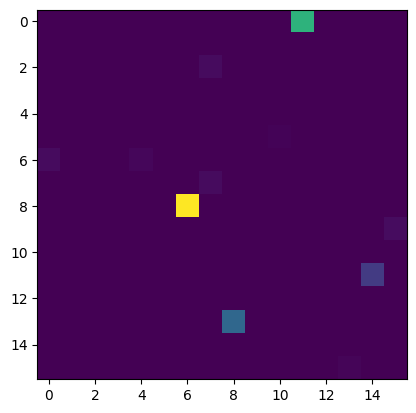

In [35]:
#NR

import matplotlib.pyplot as plt
plt.imshow(X_train[6])

# model

## embed image
Convert an image of dimension $(2^{(n/2)}, 2^{(n/2)})$ into an jnp array of dimension $2^{2n}$ with each corresponding value of the pixel mapped using the sin function.

pixel values : values from [0,1]

features values : values from [-1, 1]


$$ | \psi(x) \rangle = \sum_{i=0}^{N-1} \sum_{j=0}^{N-1} x_{ij} |i⟩ |j⟩$$


We assign a value to each pixel using the sine function and store these values in a flat array called "features." We then use this array to feed the amplitude embedding function of Pennylane.

$$ img[i,j] ---> \sin( img[i,j]) \, |i⟩ |j⟩$$

In [3]:
from typing import List
import jax.numpy as jnp
def embed_image(img: jnp.ndarray, wires: List[int]) -> None:
    # Check if the image has a single channel (grayscale, 2D)
    if img.ndim == 2:
        # If the image is 2D, make sure it is correctly reshaped
        img = img.reshape(img.shape[0], img.shape[1])  # Ensure it's treated as 2D
    
    n = len(wires) // 2

    # Initialize the feature vector with zeros
    features = jnp.zeros(2 ** (2*n))  # 2^(2*4) = 2^8 = 256 = 16x16

    # Fill the feature vector with sine-transformed pixel values
    for i in range(2**n):  # iterate in the width size (16 pixels)
        for j in range(2**n):  # iterate in the height size (16 pixels)
            features = features.at[2**n * i + j].set(
                jnp.sin(jnp.pi / 2 * (2 * img[i, j] - 1))
            )

    # Normalize the feature vector
    features = features / jnp.sqrt(jnp.sum(features**2))

    # Use amplitude embedding to encode the feature vector into the quantum state
    qml.AmplitudeEmbedding(features, wires=wires)

# Function to embed an image into a quantum state
# def embed_image(img: jnp.ndarray, wires: List[int]) -> None:
#     # n = 8
#     n = len(wires) // 2

#     # If the image is single-channel, reshape it to 2D
#     if img.shape[2] == 1:
#         img = img.reshape(img.shape[0], img.shape[1])

#     # Initialize the feature vector with zeros
#     features = jnp.zeros(2 ** (2*n)) # 2^(2*4) = 2^8 = 256 = 16x16

#     # for each pixel in the image, we asign a value using the sine function with the
#     # value of the pixel as an argument.

#     # Then, Fill the feature vector with sine-transformed pixel values
#     for i in range(2**n): # iterate in the width size (16 pixels)
#         for j in range(2**n): # iterate in the height size (16 pixels)
#             features = features.at[2**n * i + j].set(
#                 jnp.sin(jnp.pi / 2 * (2 * img[i, j] - 1))
#             )

#     # Normalize the feature vector
#     features = features / jnp.sqrt(jnp.sum(features**2))

#     # Use amplitude embedding to encode the feature vector into quantum state
#     qml.AmplitudeEmbedding(features, wires=wires)

# Function to apply a U2 gate to a pair of qubits
def U2(phi, wires):
    qml.RX(phi[0], wires=wires[0])
    qml.RX(phi[1], wires=wires[1])
    qml.IsingZZ(phi[2], wires=wires)
    qml.RX(phi[3], wires=wires[0])
    qml.RX(phi[4], wires=wires[1])
    qml.IsingYY(phi[5], wires=wires)

# Function to apply a U4 gate to four qubits
def U4(phi, wires):
    qml.RX(phi[0], wires=wires[0])
    qml.RX(phi[1], wires=wires[1])
    qml.RX(phi[0], wires=wires[2])
    qml.RX(phi[1], wires=wires[3])

    # Define the Z matrix
    Z = jnp.array([[1, 0], [0, -1]])

    # Create a Kronecker product of Z matrices for four qubits
    Z4 = jnp.kron(Z, jnp.kron(Z, jnp.kron(Z, Z)))

    # Create a diagonal matrix with phase shifts
    Z4_diag = jnp.diag(jnp.exp(1j * phi[2] * Z4))

    # Apply a diagonal unitary matrix to the four qubits
    qml.DiagonalQubitUnitary(Z4_diag, wires=wires)

# Function to apply a pooling ansatz to a pair of qubits
def Pooling_ansatz(phi, wires):
    qml.RX(phi[0], wires=wires[0])
    qml.RX(phi[1], wires=wires[1])
    qml.RY(phi[2], wires=wires[1])
    qml.RZ(phi[3], wires=wires[1])
    qml.CRX(phi[4], wires=[wires[1], wires[0]])


In [4]:
# Function to define the full QCNN (Quantum Convolutional Neural Network) circuit
def qcnn_full(params, wires, trans_inv=True):
    if trans_inv:  # 14 params
        # Apply U2 gates in a translationally invariant manner
        for i in range(int(len(wires) / 2)):
            U2(params[:6], [wires[2 * i], wires[2 * i + 1]])
        U2(params[:6], [wires[1], wires[2]])
        U2(params[:6], [wires[5], wires[6]])
        U2(params[:6], [wires[0], wires[3]])
        U2(params[:6], [wires[4], wires[7]])

        # Insert a barrier to separate different parts of the circuit
        qml.Barrier()

        # Apply U4 gates
        U4(params[6:9], wires[0:4])
        U4(params[6:9], wires[4:8])
        U4(params[6:9], wires[2:6])
        U4(params[6:9], [wires[0], wires[1], wires[6], wires[7]])

        # Insert another barrier
        qml.Barrier()

        # Apply pooling ansatz
        for i in range(int(len(wires) / 2)):
            Pooling_ansatz(params[9:14], [wires[2 * i], wires[2 * i + 1]])

        # Final barrier
        qml.Barrier()

    else:  # 93 params
        # Apply U2 gates without translational invariance
        for i in range(int(len(wires) / 2)):
            U2(params[4 * i:i * 4 + 6], [wires[2 * i], wires[2 * i + 1]])
        U2(params[24:30], [wires[1], wires[2]])
        U2(params[30:36], [wires[5], wires[6]])
        U2(params[36:42], [wires[0], wires[3]])
        U2(params[42:48], [wires[4], wires[7]])

        # Insert a barrier
        qml.Barrier()

        # Apply U4 gates
        U4(params[48:51], wires[0:4])
        U4(params[51:54], wires[4:8])
        U4(params[54:57], wires[2:6])
        U4(params[57:60], [wires[0], wires[1], wires[6], wires[7]])

        # Insert another barrier
        qml.Barrier()

        # Apply pooling ansatz
        for i in range(int(len(wires) / 2)):
            Pooling_ansatz(params[60 + i * 5:60 + i * 5 + 5], [wires[2 * i], wires[2 * i + 1]])

        # Insert a barrier
        qml.Barrier()

        # Apply another U4 gate and pooling ansatz
        U4(params[80:83], [wires[1], wires[3], wires[5], wires[7]])

        # Insert a barrier
        qml.Barrier()

        # Apply final pooling ansatz
        Pooling_ansatz(params[83:88], [wires[1], wires[3]])
        Pooling_ansatz(params[88:93], [wires[5], wires[7]])


# p4m EQNN


In this model, we work with a p4m equivariant quantum neural network whose output has been shown to be invariant under a reflection along the X and Y-axis. The model operates with 16x16 pixel images.

This version consists of U2 and U4 gates, which are applied with the same parameters to each pair or quartet of qubits, respectively. This ensures invariance under translations.

One detail is that this model consists of 4 measurements.







### 4 measurements

In [25]:
import tensorflow as tf
(X_train, y_train), (_, _) = tf.keras.datasets.mnist.load_data()

X_train = X_train.astype('float32') / 255.0  # Normalize the images

# Select 6 specific classes (e.g., digits 0, 1, 2, 3, 4, 5)
selected_classes = [0, 1, 2, 3, 4, 5]
mask = np.isin(y_train, selected_classes)
X_train = X_train[mask]
y_train = y_train[mask]
X_train= X_train[:200]
y_train= y_train[:200]

(<Figure size 2800x900 with 1 Axes>, <Axes: >)

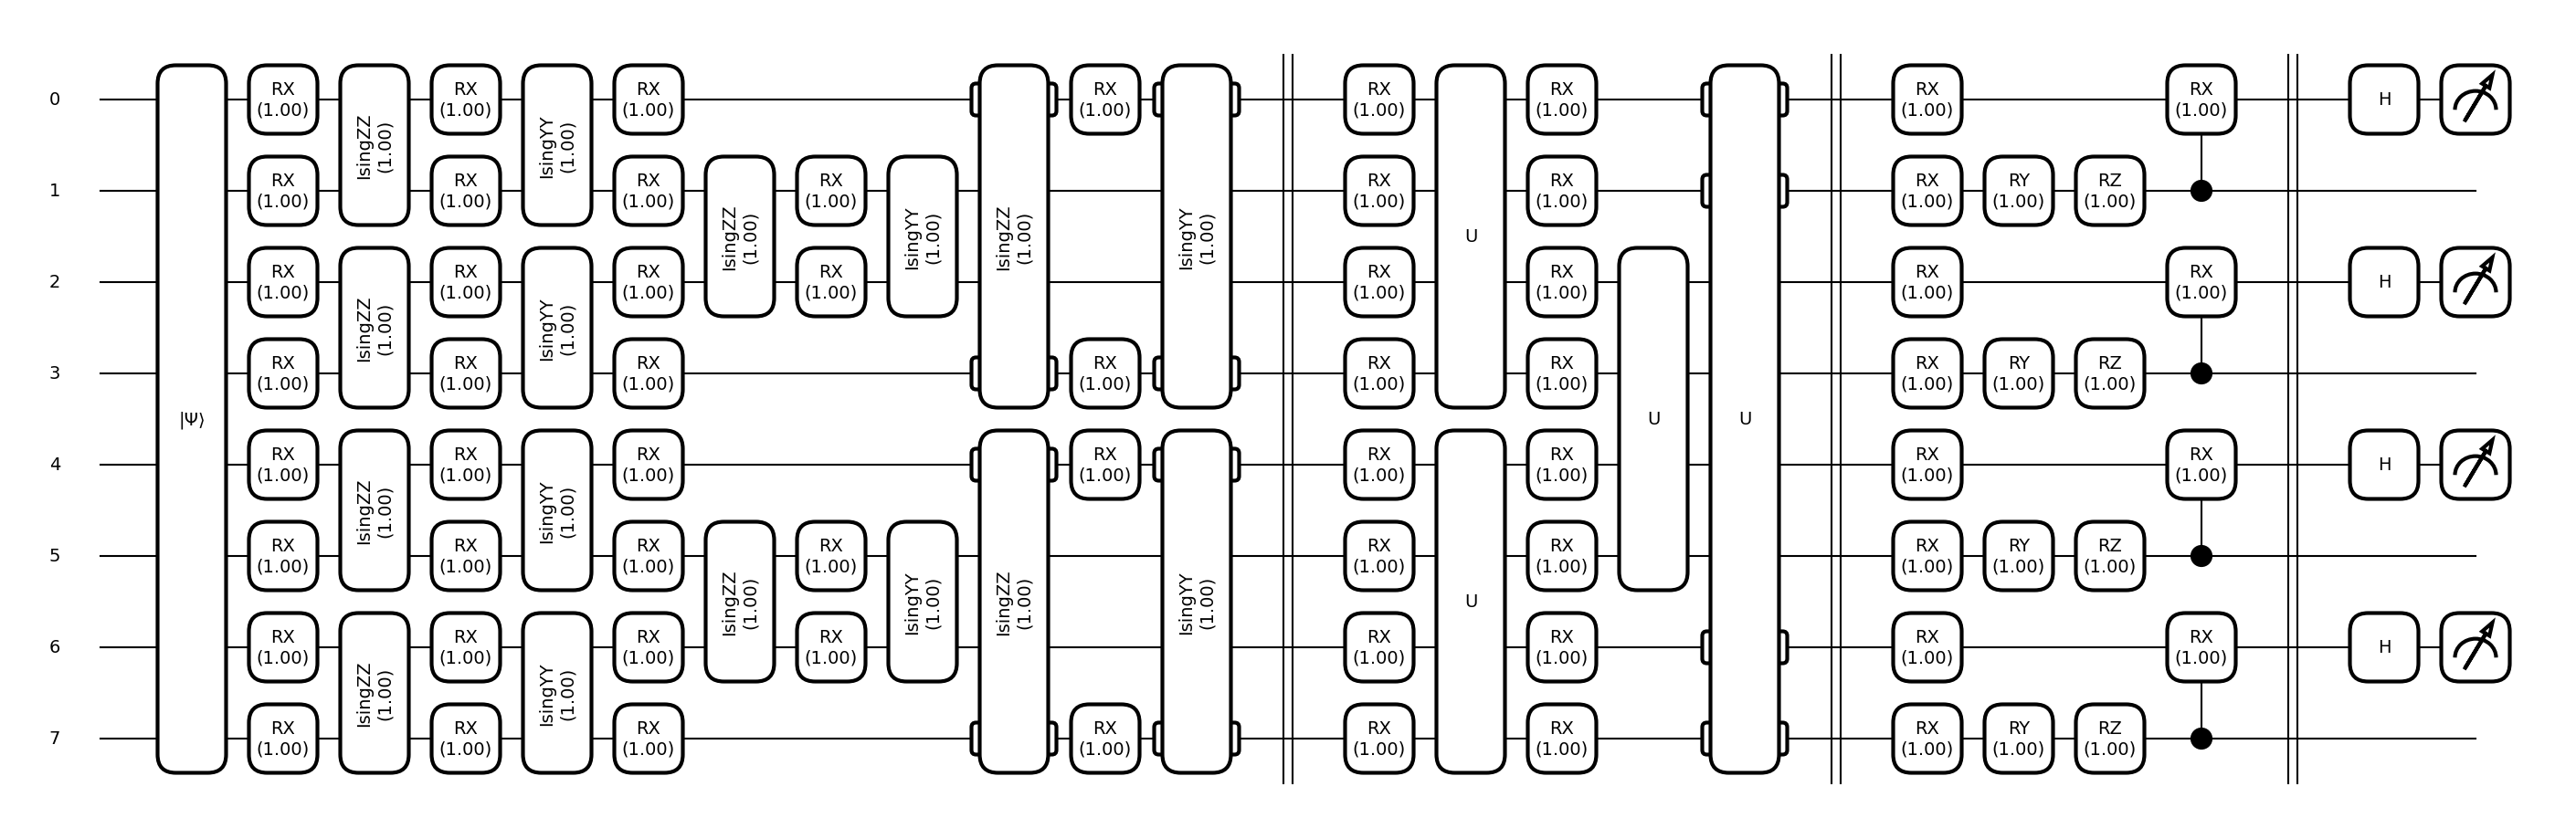

In [20]:
import pennylane as qml
import numpy as np
import jax
import jax.numpy as jnp
from typing import List

params = jnp.ones(22)
matrix = jnp.array(X_train[5])
matrix_reflected = np.fliplr(matrix)
num_qubits = 8

dev = qml.device("default.qubit", wires=num_qubits)

@jax.jit
@qml.qnode(dev, interface="jax")
def EQNN_classifier(X, params, trans_inv = True):
    embed_image(X, [0,1,2,3,4,5,6,7])
    qcnn_full(params, [0,1,2,3,4,5,6,7], trans_inv)
    qml.Hadamard(0)
    qml.Hadamard(2)
    qml.Hadamard(4)
    qml.Hadamard(6)
    return qml.probs(wires = [0,2]), qml.probs(wires = [4,6])
    #return qml.expval(qml.PauliZ(0) @ qml.PauliZ(2) @ qml.PauliZ(4) @ qml.PauliZ(6))

def draw_circuit(matrix, params):
    matrix_np = np.array(matrix)
    params_np = np.array(params)
    @qml.qnode(dev)
    def temp_circuit():
        embed_image(matrix_np, [0,1,2,3,4,5,6,7])
        qcnn_full(params_np, [0,1,2,3,4,5,6,7])
        qml.Hadamard(0)
        qml.Hadamard(2)
        qml.Hadamard(4)
        qml.Hadamard(6)
        return qml.probs(wires = [0,2]), qml.probs(wires = [4,6])

    return qml.draw_mpl(temp_circuit, decimals = 2)()

# Draw the circuit
draw_circuit(matrix, params)

In [26]:
import pennylane as qml
import numpy as np
import jax
import jax.numpy as jnp
from typing import List

dev = qml.device("default.qubit", wires=num_qubits)

def EQNN_classifier(X, params, trans_inv=True):
    # Handle the logic for trans_inv outside the JIT-compiled function
    if trans_inv:
        return EQNN_classifier_trans_inv(X, params)
    else:
        return EQNN_classifier_no_trans_inv(X, params)

# JIT-compiled function for the case when trans_inv is True
@jax.jit
@qml.qnode(dev, interface="jax")
def EQNN_classifier_trans_inv(X, params):
    embed_image(X, [0,1,2,3,4,5,6,7])
    qcnn_full(params, [0,1,2,3,4,5,6,7], trans_inv=True)
    qml.Hadamard(0)
    qml.Hadamard(2)
    qml.Hadamard(4)
    qml.Hadamard(6)
    return qml.probs(wires=[0, 2]), qml.probs(wires=[4, 6])

# JIT-compiled function for the case when trans_inv is False
@jax.jit
@qml.qnode(dev, interface="jax")
def EQNN_classifier_no_trans_inv(X, params):
    embed_image(X, [0,1,2,3,4,5,6,7])
    qcnn_full(params, [0,1,2,3,4,5,6,7], trans_inv=False)
    qml.Hadamard(0)
    qml.Hadamard(2)
    qml.Hadamard(4)
    qml.Hadamard(6)
    return qml.probs(wires=[0, 2]), qml.probs(wires=[4, 6])

# Function to extract features from the dataset
def extract_features(X, params, trans_inv=True):
    features = []
    for img in X:
        # Get quantum circuit outputs (probabilities or expectation values)
        probs = EQNN_classifier(img, params, trans_inv)
        feature_vector = np.concatenate([probs[0], probs[1]])  # You can adjust this to whatever output you need
        features.append(feature_vector)
    return np.array(features)

# Apply the quantum classifier to extract features for your whole dataset
X_train_features = extract_features(X_train, params)



/opt/conda/lib/python3.10/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.complex128'> requested in astype is not available, and will be truncated to dtype complex64. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


In [23]:
#chatgpt
import tensorflow as tf
import numpy as np
from tensorflow.keras import models, layers
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, accuracy_score
import pennylane as qml
import matplotlib.pyplot as plt
from scipy.stats import mode
from sklearn.decomposition import PCA
from scipy.optimize import minimize
from tqdm import tqdm
from sklearn.mixture import GaussianMixture

def quantum_kernel_setup(n_qubits=8, n_layers=3):
    dev = qml.device("default.qubit", wires=n_qubits)

    def feature_map(x):
        """Encodes classical data into a quantum state using RX, RY, and RZ rotations."""
        for i in range(n_qubits):
            qml.RX(x[i], wires=i)
            qml.RY(x[i], wires=i)
            qml.RZ(x[i], wires=i)

    def entanglement_layer():
        """Applies CZ gates for stronger qubit entanglement."""
        for i in range(n_qubits - 1):
            qml.CZ(wires=[i, i+1])
        qml.CZ(wires=[n_qubits - 1, 0])  # Closing the entanglement loop

    def variational_ansatz(params):
        """A deeper, more expressive variational quantum circuit."""
        for l in range(n_layers):
            for i in range(n_qubits):
                qml.RY(params[l * n_qubits + i], wires=i)
                qml.RX(params[l * n_qubits + i], wires=i)
                qml.RZ(params[l * n_qubits + i], wires=i)
            entanglement_layer()  # Apply entanglement after each layer

    @qml.qnode(dev)
    def quantum_kernel(x1, x2, params):
        feature_map(x1)
        variational_ansatz(params)
        qml.adjoint(feature_map)(x2)
        return qml.expval(qml.PauliZ(0))

    return quantum_kernel

# Function to optimize the quantum kernel and return the kernel matrix
def compute_kernel_matrix(X, params, quantum_kernel):
    N = len(X)
    kernel_matrix = np.zeros((N, N, n_qubits))  # Store full qubit measurements

    for i in tqdm(range(N)):
        for j in range(N):
            kernel_matrix[i, j] = quantum_kernel(X[i], X[j], params)
    
    return kernel_matrix.reshape(N, -1)  # Flatten qubit dimensions

# Cost Function for optimization
def cost(params, X, quantum_kernel):
    kernel_matrix = compute_kernel_matrix(X, params, quantum_kernel)
    return np.sum(kernel_matrix)

# Function to perform clustering and evaluation
def clustering_and_evaluation(kernel_matrix, X, y_train, quantum_kernel):
    # Perform K-Means Clustering on Quantum Kernel Features
    kmeans = KMeans(n_clusters=10, random_state=42)
    kmeans_labels = kmeans.fit_predict(kernel_matrix)
    # gmm = GaussianMixture(n_components=5, random_state=42)
    # kmeans_labels = gmm.fit_predict(kernel_matrix)
    # Evaluate clustering performance
    silhouette_classical = silhouette_score(X, kmeans_labels)  # Using ResNet Features
    silhouette_quantum = silhouette_score(kernel_matrix, kmeans_labels)  # Using Quantum Kernel Features
    accuracy = accuracy_score(y_train, kmeans_labels)

    # Map Clusters to MNIST Labels
    cluster_to_label = {}
    for cluster in tqdm(np.unique(kmeans_labels)):
        cluster_indices = np.where(kmeans_labels == cluster)[0]
        if len(cluster_indices) > 0:
            cluster_labels = y_train[cluster_indices]
            most_common_label = mode(cluster_labels, keepdims=True).mode[0]
            cluster_to_label[cluster] = most_common_label

    # Convert cluster labels to predicted digit classes
    y_pred = np.array([cluster_to_label[label] for label in kmeans_labels])

    # Compute corrected classification accuracy
    corrected_accuracy = accuracy_score(y_train, y_pred)
    
    return silhouette_classical, silhouette_quantum, accuracy, corrected_accuracy, y_pred



100%|██████████| 200/200 [13:43<00:00,  4.12s/it]
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
100%|██████████| 10/10 [00:00<00:00, 1058.53it/s]


Silhouette Score (ResNet Features): -0.061169185
Silhouette Score (Quantum Kernel): 0.5567005270816301
K-Means Classification Accuracy: 0.09
Corrected K-Means Classification Accuracy: 0.365


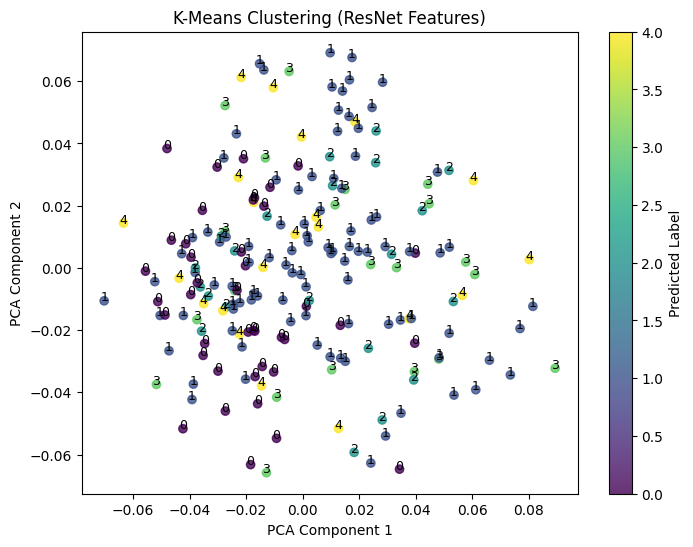

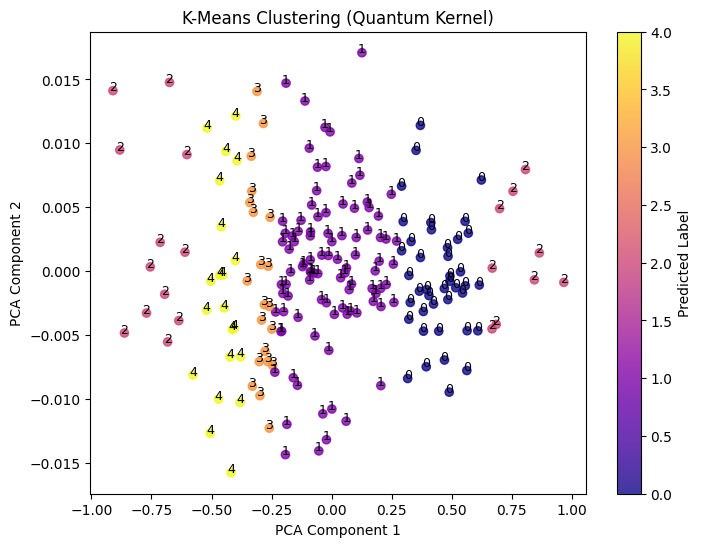

In [27]:
n_layers=3
n_qubits=8
quantum_kernel = quantum_kernel_setup()

# Initialize Parameters for optimization
params_cl = np.random.rand(n_layers * n_qubits)

# Optimize Using COBYLA
res = minimize(lambda p: cost(p, X_train_features, quantum_kernel), params_cl.flatten(), method='COBYLA', options={'maxiter': 10})
params_cl = res.x  # Update parameters

# Compute Optimized Quantum Kernel Matrix
kernel_matrix = compute_kernel_matrix(X_train_features, params_cl, quantum_kernel)

# Perform clustering and evaluate results
silhouette_classical, silhouette_quantum, accuracy, corrected_accuracy, y_pred = clustering_and_evaluation(kernel_matrix, X_train_features, y_train, quantum_kernel)

# Print Results
print("Silhouette Score (ResNet Features):", silhouette_classical)
print("Silhouette Score (Quantum Kernel):", silhouette_quantum)
print("K-Means Classification Accuracy:", accuracy)
print("Corrected K-Means Classification Accuracy:", corrected_accuracy)

# Visualize the clusters (PCA for 2D projection)
pca = PCA(n_components=2)
X_2D_resnet = pca.fit_transform(X_train_features)  # Apply PCA on ResNet features
X_2D_quantum = pca.fit_transform(kernel_matrix)  # Apply PCA on quantum kernel features

# Visualize the clusters (PCA for 2D projection of ResNet features)
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_2D_resnet[:, 0], X_2D_resnet[:, 1], c=y_pred, cmap="viridis", alpha=0.8)

# Annotate with the cluster labels (1, 0, 4, etc.)
for i, label in enumerate(y_pred):
    plt.text(X_2D_resnet[i, 0], X_2D_resnet[i, 1], str(label), fontsize=9, ha='center')

plt.title("K-Means Clustering (ResNet Features)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(scatter, label="Predicted Label")
plt.show()

# Visualize Quantum Kernel Clustering with cluster labels as text
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_2D_quantum[:, 0], X_2D_quantum[:, 1], c=y_pred, cmap="plasma", alpha=0.8)

# Annotate with the cluster labels (1, 0, 4, etc.)
for i, label in enumerate(y_pred):
    plt.text(X_2D_quantum[i, 0], X_2D_quantum[i, 1], str(label), fontsize=9, ha='center')

plt.title("K-Means Clustering (Quantum Kernel)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(scatter, label="Predicted Label")
plt.show()

In [32]:
np.save("X_train_features.npy", X_train_features)
np.save("kernel_matrix.npy", kernel_matrix)


In [ ]:
y_pred

In [16]:
y_train

array([5, 0, 4, 1, 2, 1, 3, 1, 4, 3, 5, 3, 1, 2, 4, 0, 1, 1, 2, 4],
      dtype=uint8)

In [ ]:
from tqdm import tqdm
silhouette_classical, accuracy, corrected_accuracy, y_pred = clustering_and_evaluation(X_train_features, X_train, y_train)

# Print Results
print("Silhouette Score ( Features):", silhouette_classical)
print("K-Means Classification Accuracy:", accuracy)
print("Corrected K-Means Classification Accuracy:", corrected_accuracy)

# Visualize the clusters using t-SNE for 2D projection
pca = PCA(n_components=2, random_state=42)
X_2D_resnet = pca.fit_transform(X_train_features)  # Apply t-SNE on ResNet features

# Visualize the clusters (t-SNE for 2D projection of ResNet features)
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_2D_resnet[:, 0], X_2D_resnet[:, 1], c=y_pred, cmap="viridis", alpha=0.8)

# Annotate with the cluster labels (1, 0, 4, etc.)
for i, label in enumerate(y_pred):
    plt.text(X_2D_resnet[i, 0], X_2D_resnet[i, 1], str(label), fontsize=9, ha='center')

plt.title("DBSCAN Clustering (ResNet Features)")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.colorbar(scatter, label="Predicted Label")
plt.show()

In [73]:
X_train_features

array([[0.18679637, 0.25865084, 0.26244134, ..., 0.27673796, 0.24200901,
        0.30762818],
       [0.20761052, 0.2488949 , 0.23850681, ..., 0.21660388, 0.24597797,
        0.3179358 ],
       [0.23366484, 0.2449776 , 0.20657848, ..., 0.22806305, 0.22763146,
        0.298487  ],
       ...,
       [0.20628323, 0.23794407, 0.22584167, ..., 0.22158755, 0.22927788,
        0.34905434],
       [0.2306474 , 0.24286114, 0.24227414, ..., 0.22661494, 0.23208575,
        0.30770725],
       [0.2309547 , 0.23975089, 0.23125282, ..., 0.23598531, 0.24248624,
        0.290796  ]], dtype=float32)

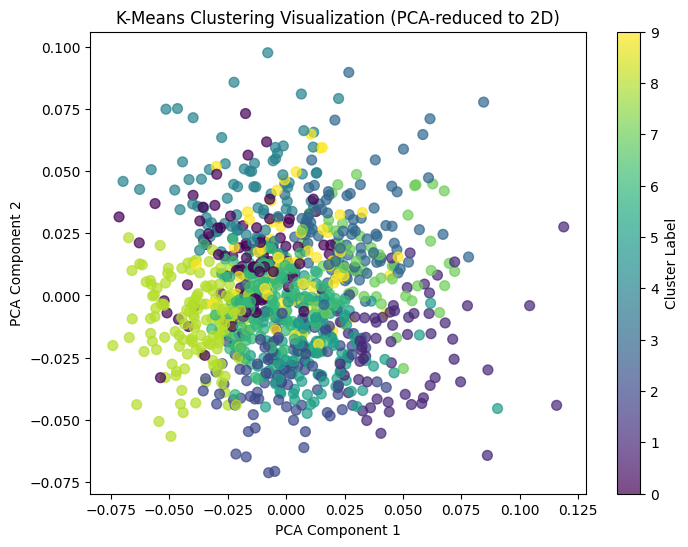

In [62]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Step 1: Apply PCA to reduce features to 2D for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_features)

# Step 2: Plot the data points and color them according to their predicted cluster label
plt.figure(figsize=(8, 6))

# Scatter plot with color map based on cluster labels
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=predicted_labels, cmap='viridis', s=50, alpha=0.7)

# Add a color bar to the plot to show the cluster labels
plt.colorbar(label='Cluster Label')

# Set title and labels
plt.title('K-Means Clustering Visualization (PCA-reduced to 2D)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')

# Show the plot
plt.show()


In [60]:
import plotly.express as px
from sklearn.decomposition import PCA

# Step 1: Apply PCA to reduce features to 3D for visualization
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_train_features)

# Step 2: Create a DataFrame with PCA components and cluster labels
import pandas as pd
df = pd.DataFrame(X_pca, columns=['PCA Component 1', 'PCA Component 2', 'PCA Component 3'])
df['Cluster Label'] = predicted_labels

# Step 3: Create the 3D scatter plot with Plotly
fig = px.scatter_3d(df, x='PCA Component 1', y='PCA Component 2', z='PCA Component 3', 
                    color='Cluster Label', color_continuous_scale='Viridis', title="K-Means Clustering Visualization (PCA-reduced to 3D)")

# Step 4: Show the interactive plot
fig.show()


In [29]:
y_train[:10]

array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4], dtype=uint8)

/opt/conda/lib/python3.10/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.complex128'> requested in astype is not available, and will be truncated to dtype complex64. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


 Output with Probabilities for Original Image: (Array([0.20794086, 0.23340383, 0.2383642 , 0.32029027], dtype=float32), Array([0.18578194, 0.23870538, 0.23296568, 0.34254616], dtype=float32))
 Output with Probabilities for Image Reflected over Y-axis: (Array([0.20794085, 0.23340385, 0.23836417, 0.32029033], dtype=float32), Array([0.18578193, 0.23870534, 0.2329657 , 0.3425462 ], dtype=float32))
 Output with Probabilities for Image Reflected over X-axis: (Array([0.20794086, 0.23340389, 0.23836422, 0.32029036], dtype=float32), Array([0.18578193, 0.2387054 , 0.23296572, 0.34254622], dtype=float32))
 Output with Probabilities for Image Rotated 90 Degrees: (Array([0.18578193, 0.23870534, 0.23296565, 0.34254616], dtype=float32), Array([0.20794082, 0.2334038 , 0.23836416, 0.32029027], dtype=float32))


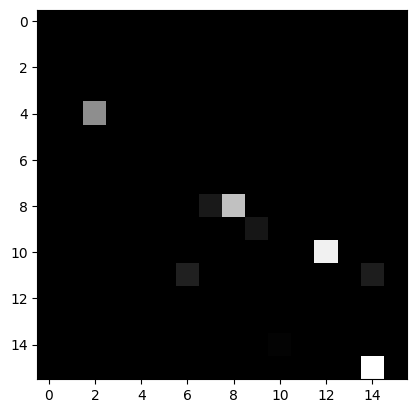

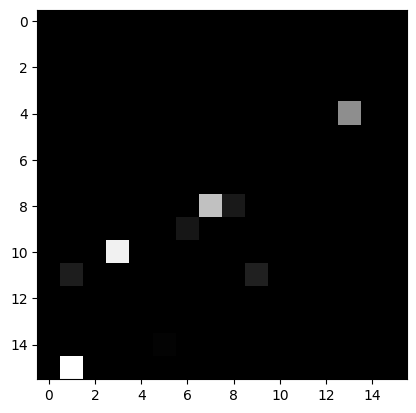

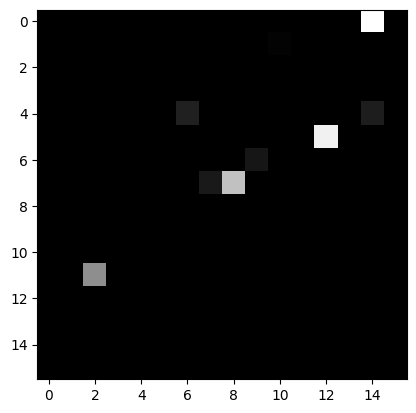

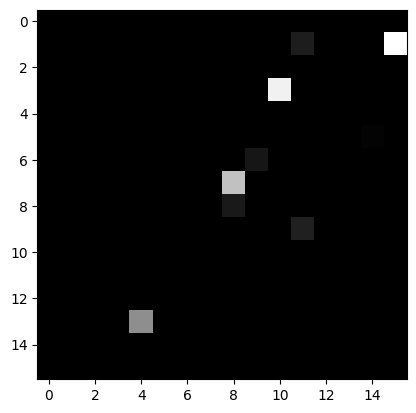

In [39]:
import matplotlib.pyplot as plt

matrix = jnp.array(X_train[7])

# Image Reflected over Y-axis
matrix_reflected_y = np.fliplr(matrix)

# Image Reflected over X-axis
matrix_reflected_x = np.flipud(matrix)

# Image rotated 90 degrees
matrix_rotated_90 = np.rot90(matrix)

# array to JAX
matrix_reflected_y_jax = jnp.array(matrix_reflected_y)
matrix_reflected_x_jax = jnp.array(matrix_reflected_x)
matrix_rotated_90_jax = jnp.array(matrix_rotated_90)


result1 = EQNN_classifier(matrix, params)
result2 = EQNN_classifier(matrix_reflected_y_jax, params)
result3 = EQNN_classifier(matrix_reflected_x_jax, params)
result4 = EQNN_classifier(matrix_rotated_90_jax, params)


print(f" Output with Probabilities for Original Image: {result1}")
print(f" Output with Probabilities for Image Reflected over Y-axis: {result2}")
print(f" Output with Probabilities for Image Reflected over X-axis: {result3}")
print(f" Output with Probabilities for Image Rotated 90 Degrees: {result4}")

plt.imshow(matrix, cmap='gray')
plt.show()
plt.imshow(matrix_reflected_y, cmap='gray')
plt.show()
plt.imshow(matrix_reflected_x, cmap='gray')
plt.show()
plt.imshow(matrix_rotated_90, cmap='gray')
plt.show()

## 2 measurements

The EQNN with only two measurements has shown that is invariant under the reflexion symmetry over the data. Nevertheless, It presents a slight difference if we apply a rotated by 90 degrees operation over the data.

(<Figure size 3400x900 with 1 Axes>, <Axes: >)

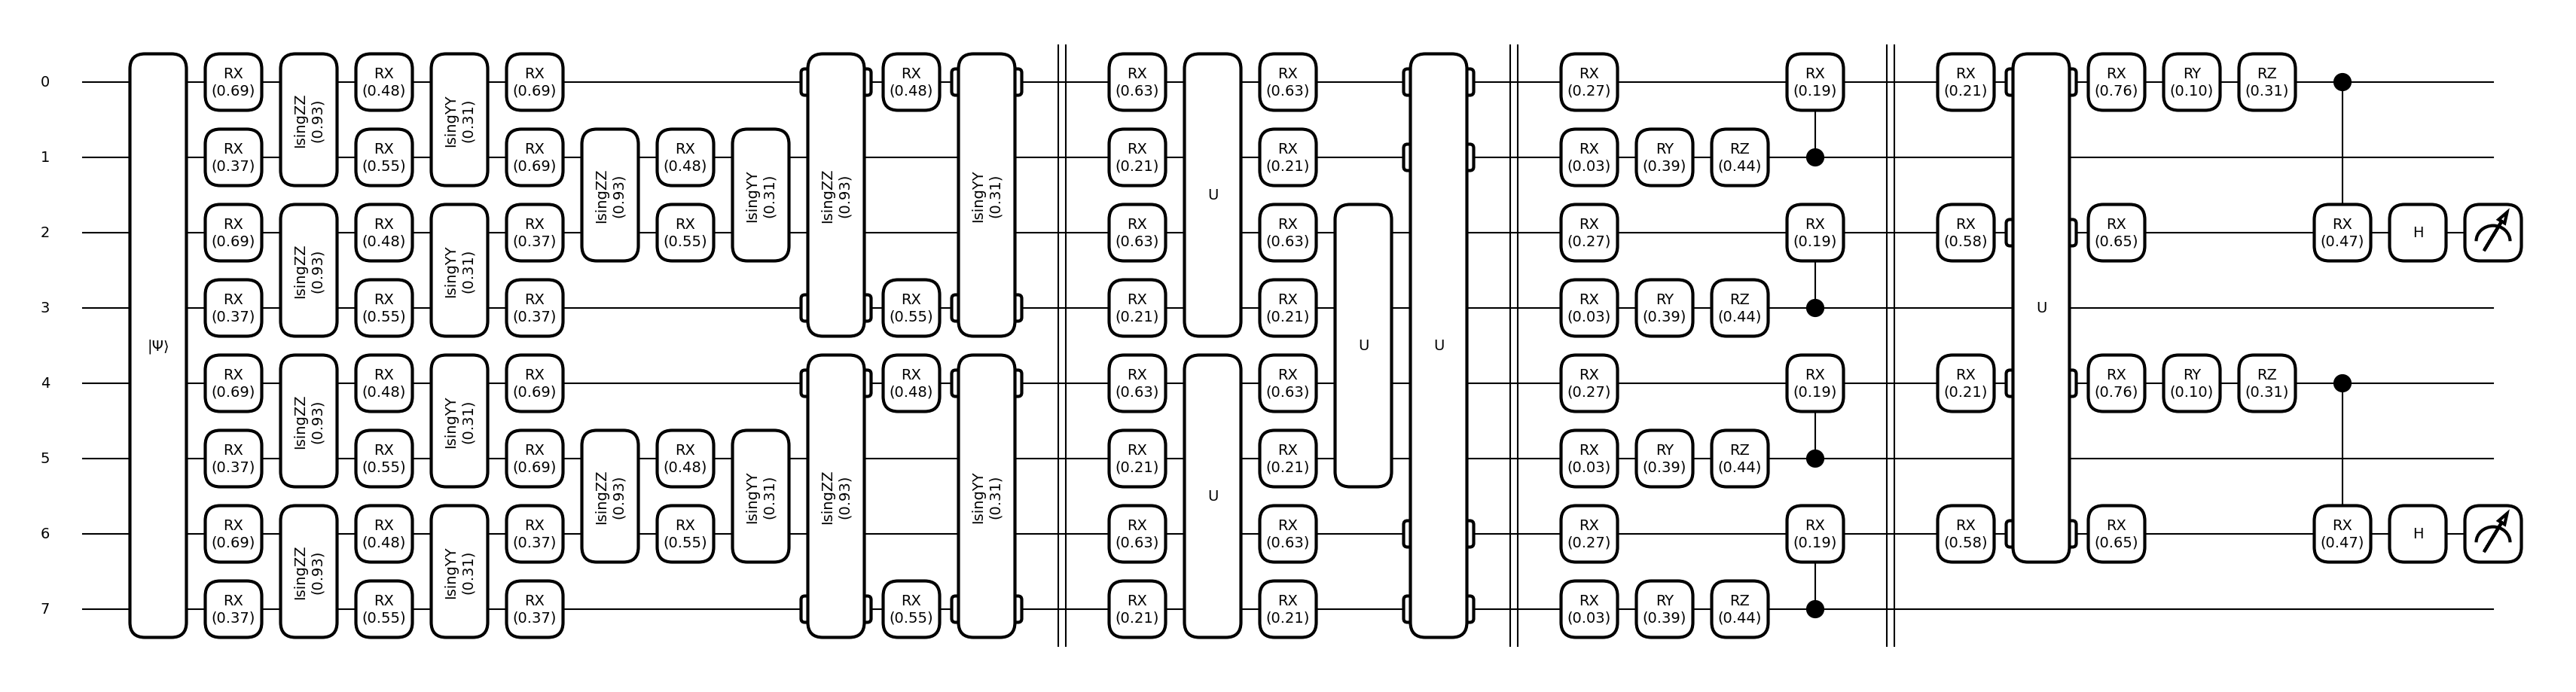

In [40]:
import pennylane as qml
import numpy as np
import jax
import jax.numpy as jnp
from typing import List

params = jnp.array(np.random.random(22))
matrix = jnp.array(X_train[1])
matrix_reflected = np.fliplr(matrix)
num_qubits = 8

dev = qml.device("default.qubit", wires=num_qubits)


@jax.jit
@qml.qnode(dev, interface="jax")
def EQNN_classifier_2m(X, params):
    embed_image(X, [0,1,2,3,4,5,6,7])
    qcnn_full(params, [0,1,2,3,4,5,6,7])
    U4(params[14:17], wires = [0,2,4,6])
    Pooling_ansatz(params[17:22], [2,0])
    Pooling_ansatz(params[17:22], [6,4])
    qml.Hadamard(2)
    qml.Hadamard(6)
    #return qml.probs(wires = [2]), qml.probs(wires = [6])
    return qml.expval(qml.PauliZ(2) @ qml.PauliZ(6))

def draw_circuit(matrix, params):
    matrix_np = np.array(matrix)
    params_np = np.array(params)
    @qml.qnode(dev)
    def temp_circuit():
        embed_image(matrix_np, [0,1,2,3,4,5,6,7])
        qcnn_full(params_np, [0,1,2,3,4,5,6,7])
        U4(params_np[14:17], wires = [0,2,4,6])
        Pooling_ansatz(params_np[17:22], [2,0])
        Pooling_ansatz(params_np[17:22], [6,4])
        qml.Hadamard(2)
        qml.Hadamard(6)
        #return qml.probs(wires = [2]), qml.probs(wires = [6])
        return qml.expval(qml.PauliZ(2) @ qml.PauliZ(6))

    return qml.draw_mpl(temp_circuit, decimals = 2)()

draw_circuit(matrix, params)


In [41]:
matrix = jnp.array(X_train[0])

# Image Reflected over Y-axis
matrix_reflected_y = np.fliplr(matrix)

# Image Reflected over X-axis
matrix_reflected_x = np.flipud(matrix)

# Image rotated 90 degrees
matrix_rotated_90 = np.rot90(matrix)

# array to JAX
matrix_reflected_y_jax = jnp.array(matrix_reflected_y)
matrix_reflected_x_jax = jnp.array(matrix_reflected_x)
matrix_rotated_90_jax = jnp.array(matrix_rotated_90)


result1 = EQNN_classifier_2m(matrix, params)
result2 = EQNN_classifier_2m(matrix_reflected_y_jax, params)
result3 = EQNN_classifier_2m(matrix_reflected_x_jax, params)
result4 = EQNN_classifier_2m(matrix_rotated_90_jax, params)


print(f" Output with Probabilities for Original Image: {result1}")
print(f" Output with Probabilities for Image Reflected over Y-axis: {result2}")
print(f" Output with Probabilities for Image Reflected over X-axis: {result3}")
print(f" Output with Probabilities for Image Rotated 90 Degrees: {result4}")

/opt/conda/lib/python3.10/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.complex128'> requested in astype is not available, and will be truncated to dtype complex64. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


 Output with Probabilities for Original Image: 0.06007002294063568
 Output with Probabilities for Image Reflected over Y-axis: 0.06007000803947449
 Output with Probabilities for Image Reflected over X-axis: 0.06006999313831329
 Output with Probabilities for Image Rotated 90 Degrees: 0.0600699782371521


In both models we have seen that the outputs mantains the same value with a high similarity for the original image, the reflected image over X and Y axis and the rotated image by 90 degrees. Then, we can say that this model is invariant under these symmetry operations.

Now, we have to train the latter model.

## Training

In [42]:
jitcircuit = jax.jit(EQNN_classifier_2m)
vcircuit = jax.vmap(jitcircuit, (None, 0), 0)


# Define your model, optimizer, and other functions here

def map_loss(params, xbatch, ybatch):
    loss = 0
    for i, x in enumerate(xbatch):
        f = jitcircuit(x, params)
        loss += (ybatch[i] - f) ** 2
    return loss / len(xbatch)

# generate minibatches for X and Y
def iterate_minibatches(inputs, targets, batch_size):
    for start_idx in range(0, inputs.shape[0] - batch_size + 1, batch_size):
        idxs = slice(start_idx, start_idx + batch_size)
        yield inputs[idxs], targets[idxs]

# Define accuracy function
def accuracy(labels, predictions):
    # Convert predictions to binary 0 or 1
    binary_predictions = [1 if p >= 0.5 else 0 for p in predictions]
    correct_predictions = sum(l == p for l, p in zip(labels, binary_predictions))
    acc = correct_predictions / len(labels)
    return acc

In [43]:
# example: calculate the loss for a batch with the first two elements
map_loss(params, X_train[:2], Y_train[:2])

Array(0.89557105, dtype=float32)

hyperparameters

In [44]:
learning_rate = 0.01
epochs = 10
batch_size = 1024

In [45]:
optimizer = optax.adam(learning_rate)

initializations of the trainable parameters and the optimizer

In [46]:
weight_shapes = {"weights": (22,)}
key1 = jax.random.PRNGKey(0)
params = jax.random.uniform(key=key1, shape=weight_shapes["weights"])

opt_state = optimizer.init(params)

In [ ]:
import time

n_train = 100000
n_test = 24000

# Training and evaluation loop
start = time.time()

hist_loss = []
hist_val_loss = []
train_accuracy = []
test_accuracy = []

for it in range(epochs):
    start_b = time.time()
    for Xbatch, ybatch in iterate_minibatches(X_train[:n_train], Y_train[:n_train], batch_size=batch_size):
        grads = jax.grad(map_loss)(params, Xbatch, ybatch)
        updates, opt_state = optimizer.update(grads, opt_state)
        params = optax.apply_updates(params, updates)

    loss = map_loss(params, X_train[:int(n_train/5)], Y_train[:int(n_train/5)])
    hist_loss.append(loss)
    val_loss = map_loss(params, X_test[:n_test], Y_test[:n_test])
    hist_val_loss.append(val_loss)

    # Calculate training and validation accuracy
    train_predictions = [jitcircuit(x, params) for x in X_train[:int(n_train/5)]]
    train_acc = accuracy(Y_train[:int(n_train/5)], train_predictions)
    train_accuracy.append(train_acc)

    test_predictions = [jitcircuit(x, params) for x in X_test[:n_test]]
    val_acc = accuracy(Y_test[:n_test], test_predictions)

    test_accuracy.append(val_acc)
    print("____")
    print(f"Epoch: {it} | Loss: {loss:.3f} | Val Loss: {val_loss:.3f} | Train Accuracy: {train_acc:.3f} | Val Accuracy: {val_acc:.3f}")
    print("____")

val_loss_final = map_loss(params, X_test[:n_test], Y_test[:n_test])
print("Final validation loss:", val_loss_final)

end = time.time()

print(f"Time for {epochs} epochs: {end - start}")

____
Epoch: 0 | Loss: 0.249 | Val Loss: 0.249 | Train Accuracy: 0.531 | Val Accuracy: 0.534
____
____
Epoch: 1 | Loss: 0.249 | Val Loss: 0.249 | Train Accuracy: 0.537 | Val Accuracy: 0.541
____
____
Epoch: 2 | Loss: 0.249 | Val Loss: 0.249 | Train Accuracy: 0.544 | Val Accuracy: 0.541
____
____
Epoch: 3 | Loss: 0.249 | Val Loss: 0.249 | Train Accuracy: 0.545 | Val Accuracy: 0.543
____


In [ ]:
plt.plot(hist_loss, label = "train loss")
plt.plot(hist_val_loss, label = "val loss")
plt.legend()

plt.show()

In [ ]:
plt.plot(train_accuracy, label = "train acc")
plt.plot(test_accuracy, label = "test acc")
plt.legend()

plt.show()